In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import sys
from pathlib import Path

# Add src/ to path
root_dir = (Path() / ".." / "..").resolve()
training_dir = str(root_dir / "training")
cache_path = str(root_dir / "solution_cache.pkl")
solver_path = "/home/advait/connect4/c4solver"
book_path = "/home/advait/connect4/7x6.book"
sys.path.append(str(root_dir / "src"))

# Enable rust logging
os.environ["RUST_LOG"] = "DEBUG"

In [10]:
import matplotlib.pyplot as plt
from c4a0.training import TrainingGen

In [30]:
gens = TrainingGen.load_all(training_dir)
gen_numbers = list(reversed(range(len(gens))))
gens.pop(-1)
gen_numbers.pop(-1)

0

In [12]:
set_sizes = [
    gen.get_games(str(training_dir)).unique_positions() # type: ignore
    for gen in gens
]

In [13]:
policy_scores = [
    gen.get_games(training_dir).score_policies(solver_path, book_path, cache_path)  # type: ignore
    for gen in gens
]

[2024-08-26T15:11:35Z DEBUG c4a0_rust::solver] Solving 0 missing positions
[2024-08-26T15:11:35Z DEBUG c4a0_rust::solver] Finished solving positions
[2024-08-26T15:11:35Z DEBUG c4a0_rust::solver] Solving 0 missing positions
[2024-08-26T15:11:35Z DEBUG c4a0_rust::solver] Finished solving positions
[2024-08-26T15:11:35Z DEBUG c4a0_rust::solver] Solving 0 missing positions
[2024-08-26T15:11:35Z DEBUG c4a0_rust::solver] Finished solving positions
[2024-08-26T15:11:36Z DEBUG c4a0_rust::solver] Solving 0 missing positions
[2024-08-26T15:11:36Z DEBUG c4a0_rust::solver] Finished solving positions
[2024-08-26T15:11:36Z DEBUG c4a0_rust::solver] Solving 0 missing positions
[2024-08-26T15:11:36Z DEBUG c4a0_rust::solver] Finished solving positions
[2024-08-26T15:11:36Z DEBUG c4a0_rust::solver] Solving 0 missing positions
[2024-08-26T15:11:36Z DEBUG c4a0_rust::solver] Finished solving positions
[2024-08-26T15:11:36Z DEBUG c4a0_rust::solver] Solving 0 missing positions
[2024-08-26T15:11:36Z DEBUG c4a

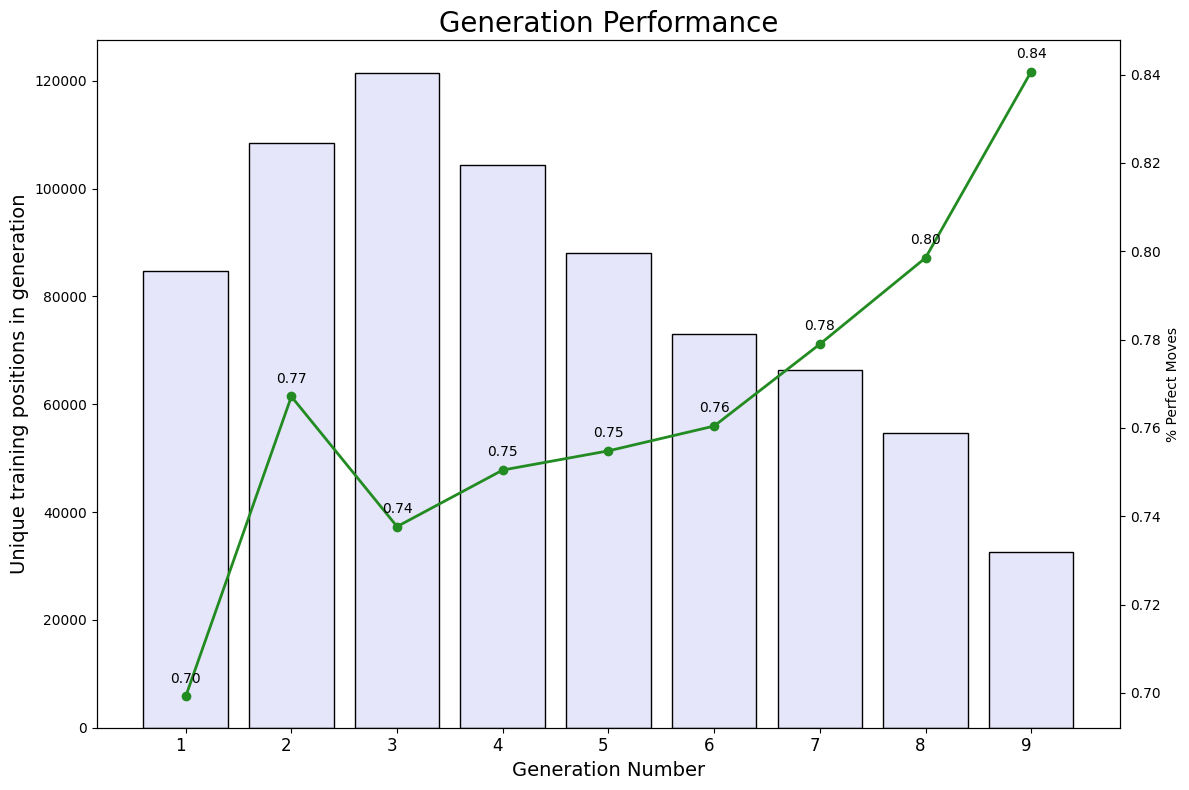

In [42]:
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for set_sizes
bars = ax1.bar(gen_numbers, set_sizes, color='lavender', edgecolor='black')
ax1.set_ylabel('Unique training positions in generation', fontsize=14)
ax1.tick_params(axis='y')
ax1.set_xlabel('Generation Number', fontsize=14)
ax1.set_xticks(gen_numbers)
ax1.set_xticklabels(gen_numbers, ha='right', fontsize=12)

# Create a second y-axis for policy_scores
ax2 = ax1.twinx()
line = ax2.plot(gen_numbers, policy_scores, color='forestgreen', marker='o', linestyle='-', linewidth=2, markersize=6)
ax2.set_ylabel('% Perfect Moves')

# Add data labels on line plot
for i, txt in enumerate(policy_scores):
    ax2.annotate(f'{txt:.2f}', (gen_numbers[i], policy_scores[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

plt.title('Generation Performance', fontsize=20)
fig.tight_layout()
plt.show()